In [1]:
#import sorting_with_python as swp
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import bessel, butter, filtfilt,  fftconvolve
#import scipy.io as sio
from neo import io
import csv
#import quantities as pq
from scipy.optimize import curve_fit
from numpy import apply_along_axis as apply 
from scipy.stats.mstats import mquantiles
from numpy.linalg import svd
from sklearn.cluster import KMeans
%matplotlib inline  
plt.ion()

plt.rcParams['agg.path.chunksize'] = 1000000
file_to_import="040826_001.wcp"
r = io.WinWcpIO( filename = file_to_import)
bl = r.read_block(lazy = False, cascade = True)
data_t = bl.segments[0].analogsignals[1]

n_rec=np.size(bl.segments)
dt=5.09e-5

data_t=[]
for i in range(0,n_rec):
    y=bl.segments[i].analogsignals[1]
    data_t=np.hstack((data_t,y))

data_x=np.linspace(0, np.size(data_t)*dt, np.size(data_t))

data_t=np.asarray(data_t)
print(data_x[-1], "seconds long" )

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/neo/io/winwcpio.py:138: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  signal = data[:,header['YO%d'%c]].astype('f4')*VMax/ADCMAX/YG * unit


(1882.5800703999998, 'seconds long')


plt.figure(figsize=(15,5))
plt.plot(data_x,data,'k')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.ylim(-1, 1)

In [2]:
#-----window of time for analisys (in seconds)----
t_1=0
t_2=1800
#-------------------------------------------------
x1= np.nonzero(data_x>t_1)
x1 = int(np.amin(x1))

x2= np.nonzero(data_x>t_2)
x2 = int(np.amin(x2))
data=data_t[x1:x2]
data_x=data_x[x1:x2]

np.set_printoptions(precision=3)
[mquantiles(data,prob=[0,0.25,0.5,0.75,1])] #for x in data]
[np.std(data)] #for x in data]
[np.min(np.diff(np.sort(np.unique(data))))] #for x in data]
data_mad=np.median(np.absolute(data - np.median(data)))*1.4826
print (data_mad)
data = (data-np.median(data))/data_mad

#plt.figure(figsize=(10,5))
#plt.plot(data_x,data,color="black")
#plt.xlim([0,0.5])

#plt.axhline(y=1,color="red")
#plt.axhline(y=-1,color="red")
#plt.axhline(y=np.std(data),color="blue",linestyle="dashed")
#plt.axhline(y=-np.std(data),color="blue",linestyle="dashed")
#plt.xlabel('Time (s)')



0.0837064590901


data_filtered = fftconvolve(data,np.array([1,1,1,1,1])/5.,'same')
#data_filtered = data_filtered.transpose() /data_mad.transpose()
data_filtered[data_filtered > -3] = 0

plt.plot(data_x, data,color='black')
plt.axhline(y=-3,color="blue",linestyle="dashed")
plt.plot(data_x, data_filtered,color='red')
plt.xlim([0,0.2])
plt.ylim([-5,10])
plt.xlabel('Time (s)')

In [3]:

#--------metodo alternativo--------

thre = -3

#---alterantive filtering----
fc_l = 2000  # low pass filter frequency
fc_h = 300   # high pass filter frequency
freq=1./dt
fc_l = fc_l/freq  # normalized frequency
fc_h = fc_h/freq  # normalized frequency
Wn = [fc_h, fc_l]
N=4          #  number of poles

#----notch filter-----------
#Wn_n = [49./freq, 51./freq]             # comment to remove notch
#b, a = butter(4, Wn_n, 'bandstop')      # comment to remove notch
#data_filtered = filtfilt(b, a, data)    # comment to remove notch
#----butter band pass filter----
b, a = butter(N, Wn, 'bandpass')
data_filtered = filtfilt(b, a, data)  
data_red = np.copy(data_filtered)
data_red[data_red > thre] = 0


#---peak detection----
peaks_p= (np.diff((data_filtered < thre)*1)==1).nonzero()[0]
peaks_n= (np.diff((data_filtered < thre)*1)==-1).nonzero()[0]
sp0=[t0+np.argmin(data_filtered[t0:t1]) for t0,t1 in zip(peaks_p,peaks_n)]

#---plotting-----
#plt.figure(figsize=(23,5))
#plt.plot(data_x, data_filtered,color='black')                 # filtered data 
#plt.axhline(y=-thre, color="blue",linestyle="dashed")         # threshold
#plt.plot(data_x, data_red,color='red')                        # peak region
#plt.plot(data_x[sp0], data_filtered[sp0],"bo")                # peaks
#plt.xlim([0,100])
#plt.ylim([-10,10])
#plt.xlabel('Time (s)')

c=len(sp0)
p=c*31.

n= np.zeros((c,60))
print(np.shape(n))

plt.figure()

for i in range(0,c): 
    a= int(sp0[i]-30)
    b= int(sp0[i]+30)
  
    n[i,]=data[a:b]
    plt.plot(n[i,].T)

c=len(sp0)
p=c*31.

n= np.zeros((c,60))
print(np.shape(n))

plt.figure()

for i in range(0,c): 
    a= int(sp0[i]-30)
    b= int(sp0[i]+30)
  
    n[i,]=data_filtered[a:b]
    plt.plot(n[i,].T)
print(np.shape(n))

c=len(sp0) 
p=c*31.

n= np.zeros((c,60))
#print(np.shape(n))

plt.figure()

for i in range(0,c): 
    a= int(sp0[i]-30) 
    b= int(sp0[i]+30)

    n[i,]=data_filtered[a:b]
    plt.plot(n[i,].T)

print(np.shape(n.T))


In [4]:
def mad(x):
    """Returns the Median Absolute Deviation of its argument.
    """
    return np.median(np.absolute(x - np.median(x)))*1.4826

In [5]:
#---points before and after peaks----
before = 30
after = 45
#------------------------------------
c=len(sp0)
#p=c*31.

evtsE= np.zeros((c,before + after))
print(np.shape(evtsE))

for i in range(0,c): 
    a= int(sp0[i]-before)
    b= int(sp0[i]+after)
    #n=data_filtered[a:b]
    evtsE[i,]=data_filtered[a:b]
evtsE_median=apply(np.median,0,evtsE)
evtsE_mad1= apply(mad,0,evtsE)

rest=evtsE - evtsE_median
abso=apply(np.absolute,0,rest)
evtsE_mad=apply(np.median,0,abso)
evtsE_mad2=evtsE_mad*1.4826
evtsE_prom=np.mean(evtsE,axis=0)


(13415, 75)


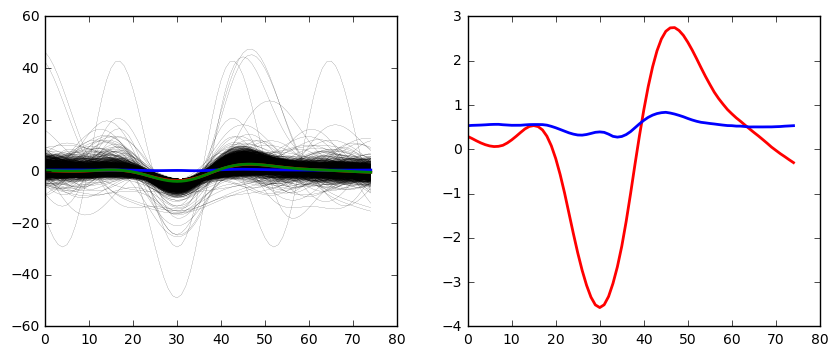

In [6]:
n= np.zeros((c,np.shape(evtsE)[1]))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(evtsE.T, color='black', lw=0.1 )
plt.plot(evtsE_median, color='red', lw=2)
plt.plot(evtsE_mad, color='blue', lw=2)
plt.plot(evtsE_prom, color='green', lw=2)
plt.subplot(1,2,2)

plt.plot(evtsE_median, color='red', lw=2)
plt.plot(evtsE_mad, color='blue', lw=2)


commented cell below


thr=3
above = evtsE_median > 0
evtsE_r = evtsE.copy()
for i in range(evtsE.shape[0]): evtsE_r[i,above] = 0
evtsE_median[above] = 0
goodEvts = (abs((evtsE-evtsE_median)/evtsE_mad) < thr)
#print ("goodEvts")
#print (goodEvts)
print(np.shape(evtsE[goodEvts]))

def good_evts_fct(samp, thr=3):
    samp_med = apply(np.median,0,samp)
    samp_mad = apply(swp.mad,0,samp)
    above = samp_med > 0
    samp_r = samp.copy()
    for i in range(samp.shape[0]): samp_r[i,above] = 0
    samp_med[above] = 0
    res = apply(lambda x:
    np.all(abs((x-samp_med)/samp_mad) < thr),1,samp_r)
    return res

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


('Good spikes : ', 13378)
('Bad spikes  : ', 37)
('All spikes  : ', 13415)


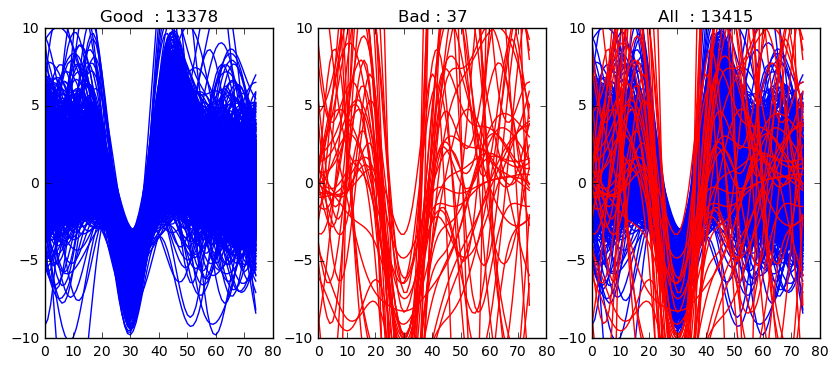

In [7]:
#-- tolerance, lower is high tolerance----
thre_events=12
import sorting_with_python as swp

samp_med = apply(np.median,0,evtsE)
samp_mad = apply(swp.mad,0,evtsE)
#samp_mad = mad(evtsE)
above = samp_med > 0
samp_r = evtsE.copy()
for i in range(evtsE.shape[0]): samp_r[i,above] = 0
samp_med[above] = 0
goodEvts = apply(lambda x:np.all(abs((x-samp_med)/samp_mad) < thre_events),1,samp_r)
#print(goodEvts)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(evtsE[goodEvts].T, color="blue")
plt.ylim(-10,10)
plt.title("Good  : " + str(np.shape(evtsE[goodEvts])[0]) )
plt.subplot(1,3,2)
plt.plot(evtsE[goodEvts.__neg__()].T, color="red")

plt.ylim(-10,10)
plt.title("Bad : " + str(np.shape(evtsE[goodEvts.__neg__()])[0]))
plt.subplot(1,3,3)
#plt.plot(evtsE.T, color="black")
plt.plot(evtsE[goodEvts].T, color="blue")
plt.plot(evtsE[goodEvts.__neg__()].T, color="red")
plt.ylim(-10,10)
plt.title("All  : " + str(str(np.shape(evtsE)[0]) ))

print("Good spikes : ", np.shape(evtsE[goodEvts])[0])
print("Bad spikes  : ", np.shape(evtsE[goodEvts.__neg__()])[0])
print("All spikes  : ", np.shape(evtsE)[0])

In [8]:
del data, data_t,data_filtered, data_red


In [9]:
varcovmat = np.cov(evtsE[goodEvts,:].T)
u, s, v = svd(varcovmat)

evt_idx = range(np.shape(evtsE)[1])
evtsE_good_mean = np.mean(evtsE[goodEvts,:],0)
#plt.figure(figsize=(10,6))
#for i in range(8):
#    plt.subplot(2,4,i+1)
#    plt.plot(evt_idx,evtsE_good_mean, "black",evt_idx, evtsE_good_mean + 5 * u[:,i],"red",evt_idx,evtsE_good_mean - 5 * u[:,i], "blue")
#    plt.title("PC" + str(i) + ": " + str(round(s[i]/sum(s)*100)) +"%")

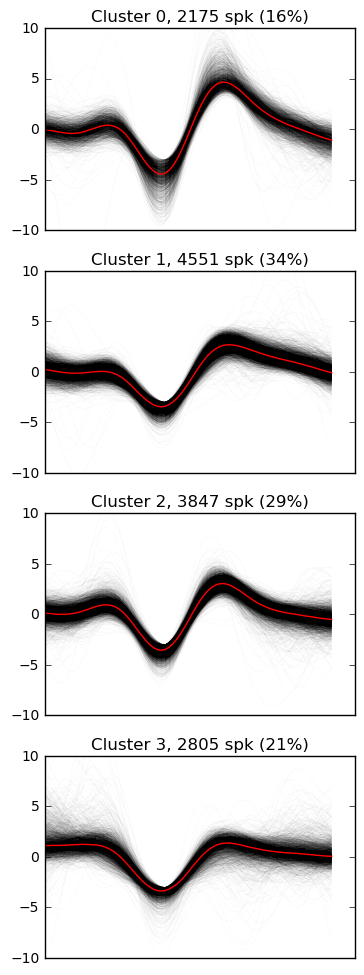

In [10]:
n_clusters=4
#------make sorting----------
km10 = KMeans(n_clusters, init="k-means++", n_init=100, max_iter=100)
km10.fit(np.dot(evtsE[goodEvts,:],u[:,0:3]))
c10 = km10.fit_predict(np.dot(evtsE[goodEvts,:],u[:,0:3]))
cluster_median = list([(i,np.apply_along_axis(np.median,0,evtsE[goodEvts,:][c10 == i,:])) for i in range(10) if sum(c10 == i) > 0])
cluster_size = list([np.sum(np.abs(x[1])) for x in cluster_median])
new_order = list(reversed(np.argsort(cluster_size)))
new_order_reverse = sorted(range(len(new_order)), key=new_order.__getitem__)
c10b = [new_order_reverse[i] for i in c10]

#-----plot clusters----------
n_plot = evtsE.shape[0]
plt.figure(figsize=(4,12))
for j in range(n_clusters):
    n_traces = np.shape(evtsE[goodEvts,:][np.array(c10b) == j,:])[0]
    plt.subplot(n_clusters, 1, j+1)
    #print("number of traces for cluster", j, "is ",n_traces)
    #for i in range(n_traces):
    plt.plot(evtsE[goodEvts,:][np.array(c10b) == j,:].T , color="black", lw=.01)
    MEDIAN = apply(np.median,0,evtsE[goodEvts][np.array(c10b) == j,:])
    plt.plot(MEDIAN, color="red", lw=1)
    n_spk_cluster = np.shape(evtsE[goodEvts,:][np.array(c10b) == j,:])[0]
    fract_spk = n_spk_cluster*100.0/np.asarray(np.shape(c10b))
    tit = "Cluster "+str(j) +", " + str(n_spk_cluster) +" spk (" + "%.0f" % fract_spk + "%)"
    plt.title(tit)
    plt.xticks([])
    plt.ylim(-10,10)
   

In [11]:
del u, v, varcovmat

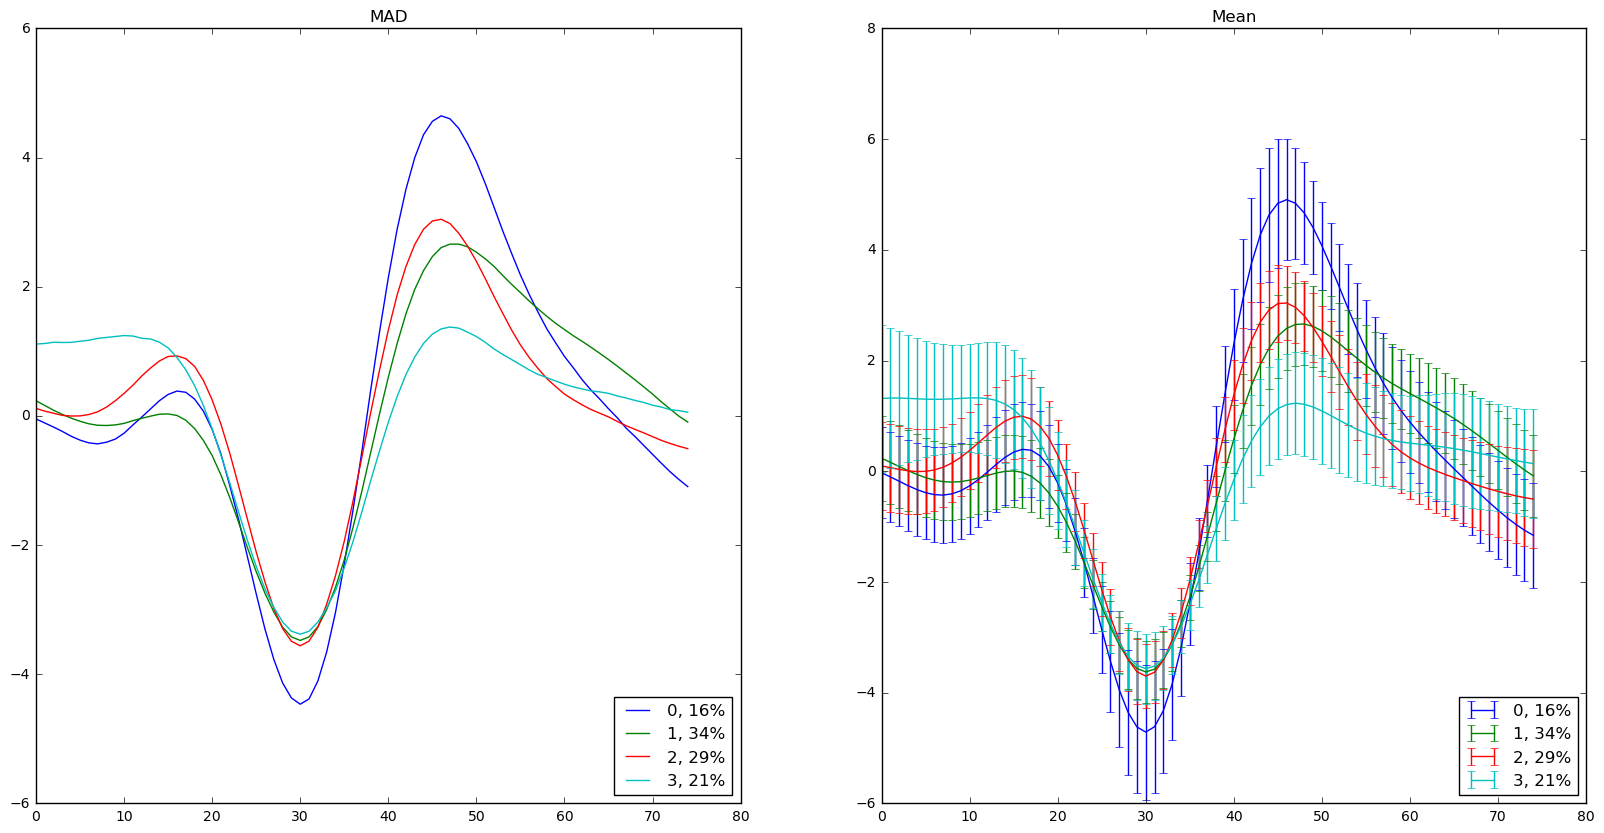

In [12]:
plt.figure(figsize=(20,10))
for j in range(n_clusters):
    #--plot median---
    plt.subplot(1,2,1)
    n_spk_cluster = np.shape(evtsE[goodEvts,:][np.array(c10b) == j,:])[0]
    fract_spk = n_spk_cluster*100.0/np.asarray(np.shape(c10b))
    #n_traces = np.shape(evtsE[goodEvts,:][np.array(c10b) == j,:])[0]
    MEDIAN = apply(np.median,0,evtsE[goodEvts][np.array(c10b) == j,:])
    plt.plot(MEDIAN, lw=1, label=str(j)+", %.0f" % fract_spk +"%")
    #plt.xticks([])
    plt.title("MAD")
    #--plot avergage---
    plt.subplot(1,2,2)
    #plt.plot(np.mean(evtsE[goodEvts][np.array(c10b) == j,:], axis=0), lw=1, label=str(j))
    #   std
    error = np.std(evtsE[goodEvts][np.array(c10b) == j,:], axis=0) #/ np.math.sqrt( np.asarray(np.shape(c10b)) )
    plt.errorbar(range(before+after), np.mean(evtsE[goodEvts][np.array(c10b) == j,:], axis=0), yerr=error, lw=1, 
                 label=str(j)+", %.0f" % fract_spk +"%")
    plt.title("Mean")
plt.legend(loc="lower right")
plt.subplot(1,2,1)
plt.legend(loc="lower right")

(13378,)
(1, 2175)
(1, 4551)
(1, 3847)
(1, 2805)


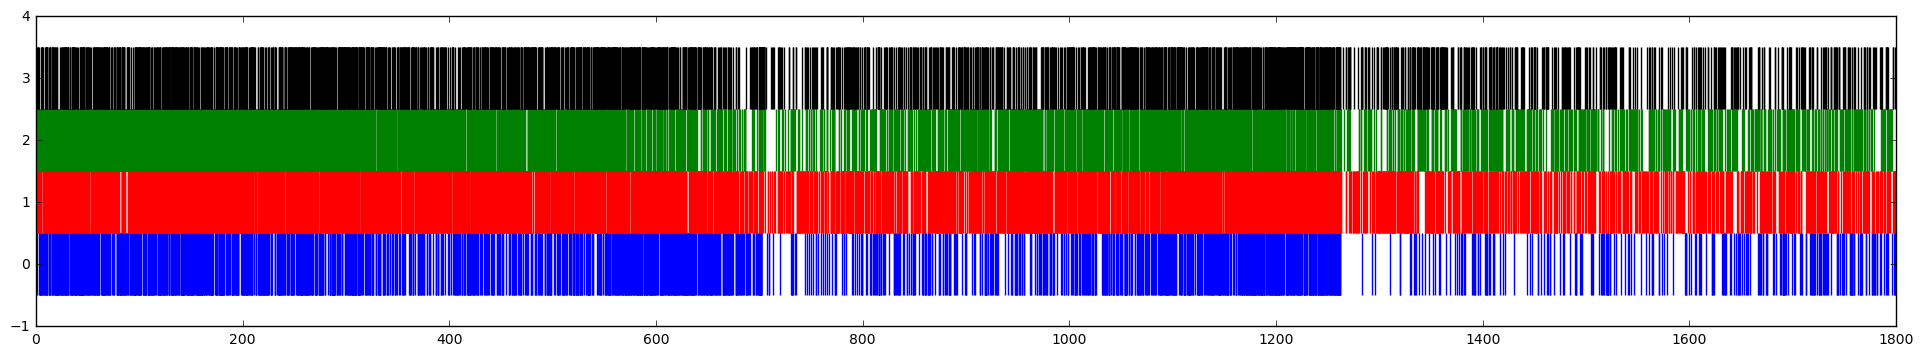

In [13]:
plt.figure(figsize=(24,4))
bad_events_ind  = np.where(goodEvts==0)   # indeces of bad spikes in goodEvts
times = np.delete(data_x[sp0], bad_events_ind, axis=0)
print(np.shape(times))
mat=[]
colors1=["b","r","g","k"]
for j in range(n_clusters):
    #p_cluster = np.where(np.array(c10b) == j)
    p_cluster = np.nonzero(np.array(c10b) == j)
    print(np.shape(p_cluster))
    #raster = np.full(np.shape(p_cluster)[1], j )
    #print(np.shape(times[p_cluster]), np.shape(raster))
    plt.eventplot(times[p_cluster],lineoffsets=j, color=colors1[j])
    #plt.eventplot(mat,lineoffsets=1)
    plt.xlim(0,data_x[-1])



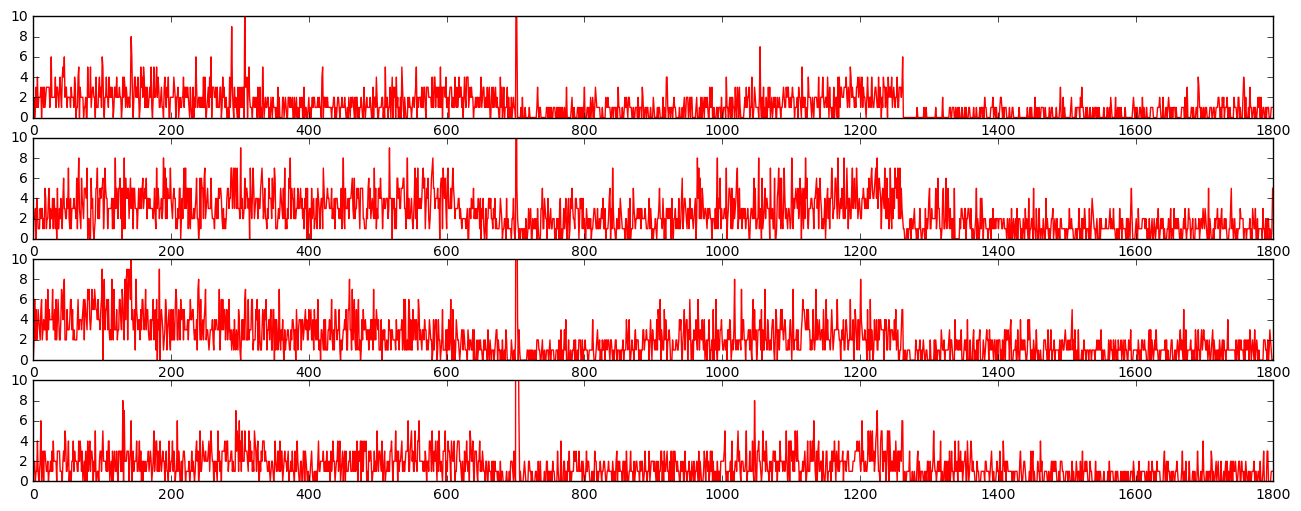

In [23]:
time_event= 1 #tiempo evento en segundos
plt.figure(figsize=(16,6))
n_bin=np.int(np.round(data_x[-1]/time_event))
for j in range(n_clusters):
    n_traces = np.shape(evtsE[goodEvts,:][np.array(c10b) == j,:])[0]
    p_cluster = np.where(np.array(c10b) == j)
    rate=[]
    t_bins=np.arange(n_bin)
    t_bins=t_bins*time_event

    for i in range (n_bin):
        t_i=i*time_event
        t_f=(i+1)*time_event-1
        isi_bin=np.nonzero(times[p_cluster]<t_f)
        rate.append(np.shape(isi_bin)[1])
    rate_1=rate[0]/time_event
    rate_2=np.diff(np.asarray(rate))
    rate_2=rate_2/time_event
    rate_2=np.insert(rate_2,0,rate_1)
    plt.subplot(n_clusters, 1, j+1)
    plt.plot(t_bins,rate_2,color='r')
    plt.ylim(0,10)


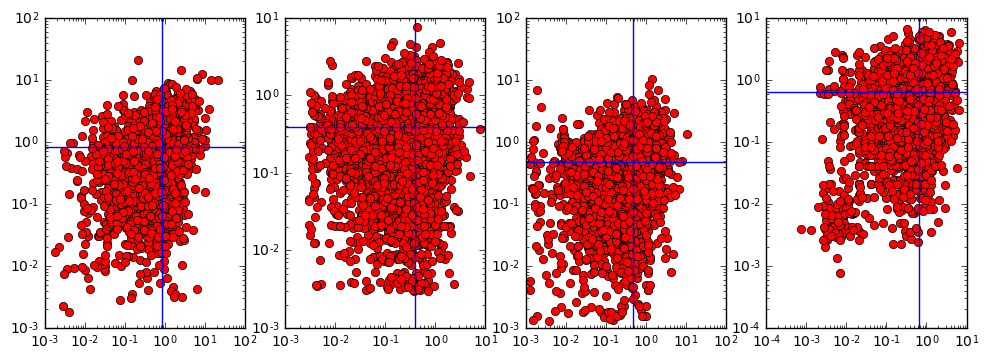

In [15]:
plt.figure(figsize=(15,4))
for j in range(n_clusters):
    p_cluster = np.nonzero(np.array(c10b) == j)
    isi = np.diff(times[p_cluster])     # ISI 
    m_l = np.mean(isi);
    isi_i   = isi.copy()
    isi_i_1 = isi.copy()
    isi_i =   np.delete(isi,-1)  # del isi_i[-1]
    isi_i_1 = np.delete(isi,0)  #del isi_i_1[-1]
 
    plt.subplot(1, n_clusters +1, j +1);
    plt.loglog(isi_i, isi_i_1, "or")
    plt.axhline(m_l)
    plt.axvline(m_l)
)

In [16]:
print(times[p_cluster][0:9])
print("----")
print(isi[0:9])
print(isi_i[0:9])
print(isi_i_1[0:9])

[ 0.168  0.61   1.877  1.881  3.304  4.77   5.452  5.512  5.76 ]
----
[ 0.442  1.267  0.004  1.423  1.465  0.682  0.06   0.248  0.173]
[ 0.442  1.267  0.004  1.423  1.465  0.682  0.06   0.248  0.173]
[ 1.267  0.004  1.423  1.465  0.682  0.06   0.248  0.173  0.434]


In [17]:
whos


Variable            Type            Data/Info
---------------------------------------------
KMeans              type            <class 'sklearn.cluster.k_means_.KMeans'>
MEDIAN              ndarray         75: 75 elems, type `float64`, 600 bytes
N                   int             4
Wn                  list            n=2
a                   int             35358275
above               ndarray         75: 75 elems, type `bool`, 75 bytes
abso                ndarray         13415x75: 1006125 elems, type `float64`, 8049000 bytes (7 Mb)
after               int             45
apply               function        <function apply_along_axis at 0x7f6f500ff7d0>
b                   int             35358350
bad_events_ind      tuple           n=1
before              int             30
bessel              function        <function bessel at 0x7f6f2a9746e0>
bl                  Block           <neo.core.block.Block object at 0x7f6f1ddf1f10>
butter              function        <function butter at 0x7f